In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('fresno_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,93605,Fresno County,1,2015,Residential,61299.0,0.061299
1,93629,Fresno County,1,2015,Residential,238667.0,0.238667
2,93629,Fresno County,1,2015,Industrial,161803646.0,161.803646
3,93605,Fresno County,1,2016,Residential,70050.0,0.070050
4,93629,Fresno County,1,2016,Residential,298590.0,0.298590


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        422 non-null    int64  
 1   County         422 non-null    object 
 2   Month          422 non-null    int64  
 3   Year           422 non-null    int64  
 4   CustomerClass  422 non-null    object 
 5   TotalkWh       422 non-null    float64
 6   TotalGWh       422 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 23.2+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        422 non-null    int64         
 1   County         422 non-null    object        
 2   Month          422 non-null    int64         
 3   Year           422 non-null    int64         
 4   CustomerClass  422 non-null    object        
 5   TotalkWh       422 non-null    float64       
 6   TotalGWh       422 non-null    float64       
 7   Date           422 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 26.5+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,93605,Fresno County,1,2015,Residential,61299.0,0.061299
2015-01-01,93629,Fresno County,1,2015,Residential,238667.0,0.238667
2015-01-01,93629,Fresno County,1,2015,Industrial,161803646.0,161.803646
2016-01-01,93605,Fresno County,1,2016,Residential,70050.0,0.070050
2016-01-01,93629,Fresno County,1,2016,Residential,298590.0,0.298590


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,162103612.0,162.103612
2015-02-28,102878872.0,102.878872
2015-03-31,95236750.0,95.236750
2015-04-30,173082143.0,173.082143
2015-05-31,100261555.0,100.261555


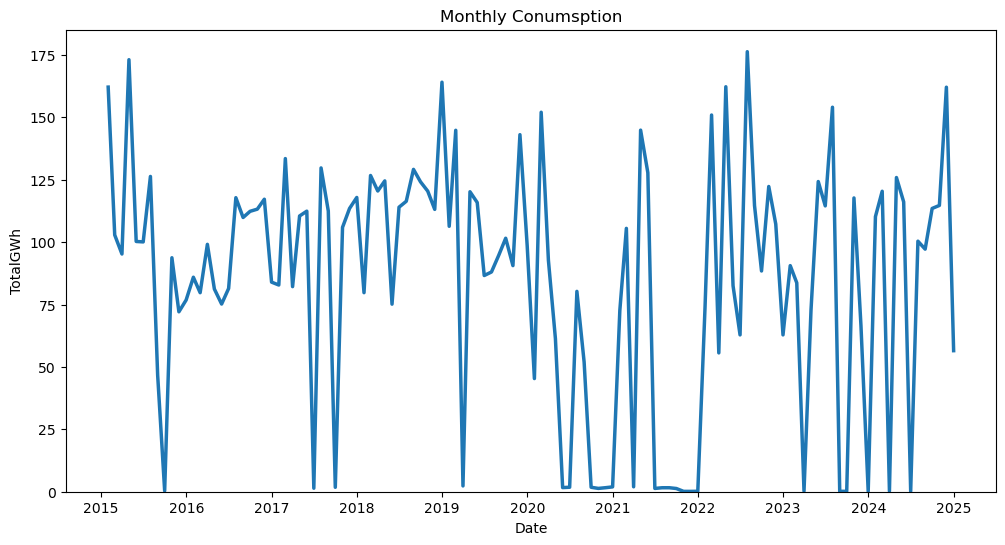

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=2.5)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -1.7966245797306923
p-value: 0.3821387791482119
Non-Stationary


***SARIMAX model can still handle non-stationary data***

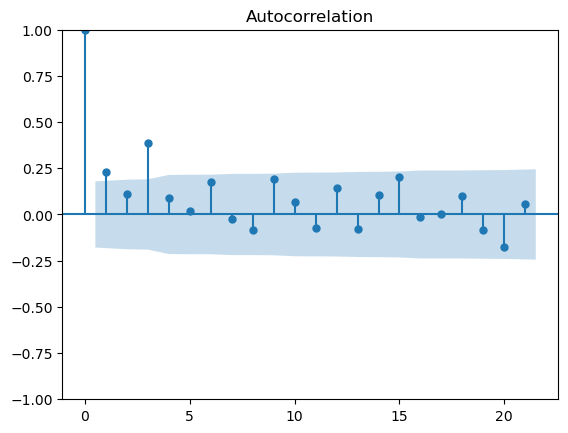

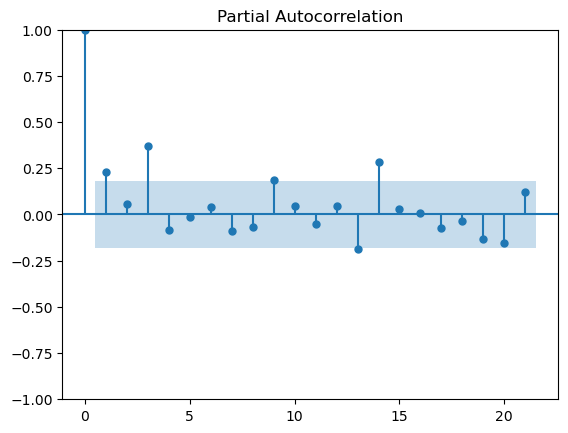

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1318.337, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1296.212, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1266.198, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1316.363, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1265.374, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1265.594, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1267.031, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1266.837, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1297.938, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1264.205, Time=0.05 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=1261.944, Time=0.12 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=1256.227, Time=0.36 sec
 ARIMA(1,1,2)(2,0,1)[12] inte

In [18]:
# p, d, q parameters
model.order

(1, 1, 2)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

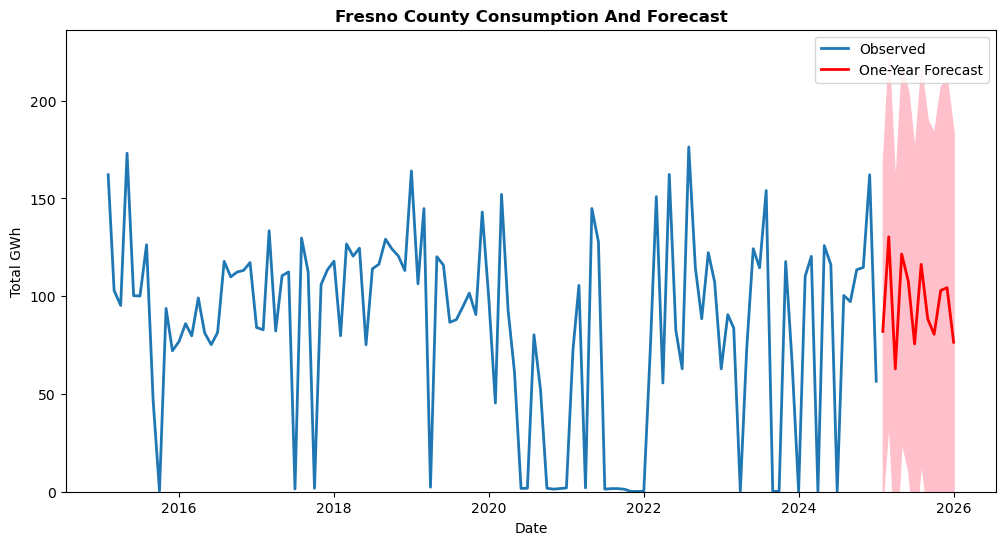

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed', linewidth=2)
plt.plot(forecast_mean, label='One-Year Forecast', color='red', linewidth=2)
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Fresno County Consumption And Forecast", weight='bold')
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

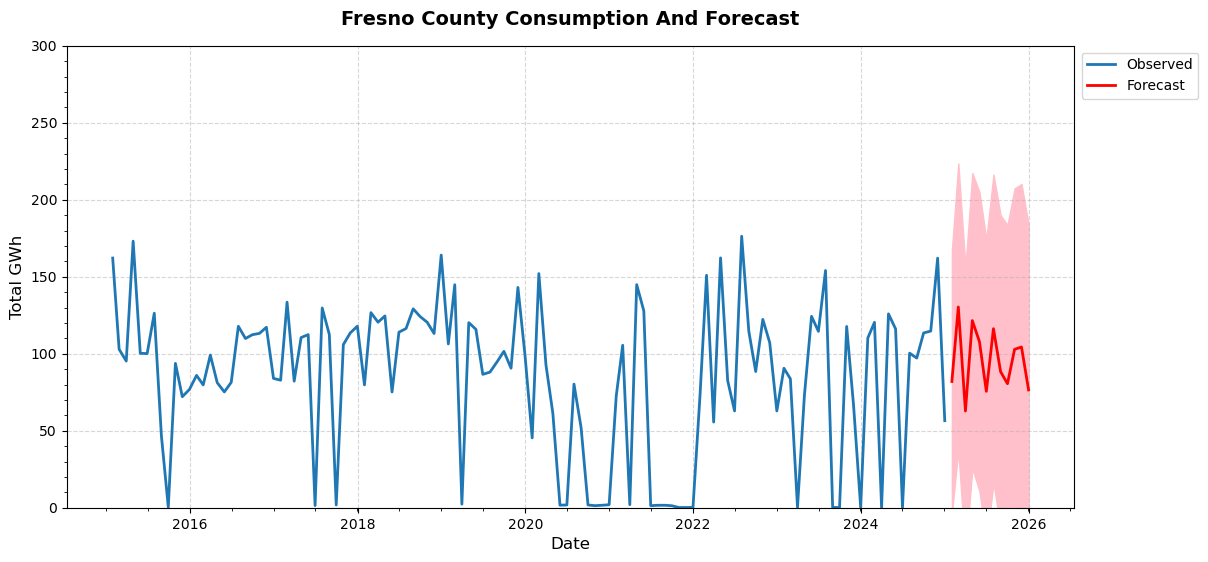

In [31]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(13, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Fresno County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0,top=300)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.13,1), loc='upper right')

# Show plot
#plt.savefig('fresno_c.png')
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 28.00522341862376
MSE: 1323.2838623138755
RMSE: 36.37696884450209


In [24]:
observed

Date
2024-01-31    110.218887
2024-02-29    120.383850
2024-03-31      0.223435
2024-04-30    125.881795
2024-05-31    116.107355
2024-06-30      0.146376
2024-07-31    100.375302
2024-08-31     97.192932
2024-09-30    113.493465
2024-10-31    114.703109
2024-11-30    162.065636
2024-12-31     56.513015
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2025-01-31     81.973961
2025-02-28    130.346014
2025-03-31     62.814237
2025-04-30    121.522036
2025-05-31    107.812403
2025-06-30     75.587340
2025-07-31    116.247608
2025-08-31     88.364811
2025-09-30     80.517488
2025-10-31    102.871327
2025-11-30    104.357372
2025-12-31     76.465679
Freq: M, Name: predicted_mean, dtype: float64

In [26]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Commercial        23.137343
Industrial     10044.561912
Residential       98.278817
Name: TotalGWh, dtype: float64

In [27]:
customer_df = customer_consum.reset_index()

In [28]:
customer_df

,CustomerClass,TotalGWh
0,Commercial,23.137343
1,Industrial,10044.561912
2,Residential,98.278817


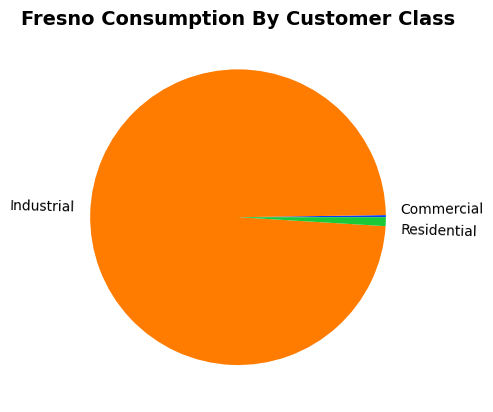

In [29]:
# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass'], rotatelabels=True
       ,colors=palette_color)
plt.title('Fresno Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.show()

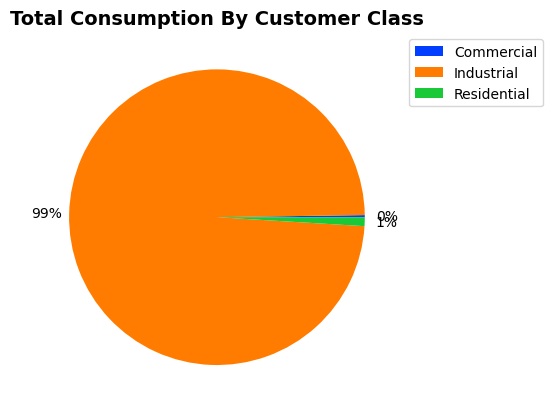

In [30]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'],colors=palette_color, autopct='%.0f%%',pctdistance=1.15, textprops=dict(color='black'),rotatelabels=True)
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()